## Импорт библиотек

In [ ]:
import pandas as pd
import plotly.express as px

## Загрузим данные

In [2]:
# 1_market_access.parquet
market_access = pd.read_parquet('data/1_market_access.parquet')
market_access

,territory_id,market_access
0,1,309.6
1,2,322.8
2,3,315.2
3,4,315.5
4,5,320.2
...,...,...
2566,3011,307.9
2567,3012,307.7
2568,3013,465.6
2569,3014,473.7


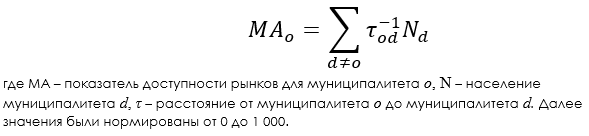

In [5]:
# 2_bdmo_population.parquet
population = pd.read_parquet('data/2_bdmo_population.parquet')
population

,territory_id,year,period,age,gender,value
0,1402,2023,год,0,Женщины,288.0
1,1402,2023,год,0,Мужчины,301.0
2,1402,2023,год,1,Женщины,277.0
3,1402,2023,год,1,Мужчины,316.0
4,1402,2023,год,10,Женщины,414.0
...,...,...,...,...,...,...
700210,1401,2024,год,8,Мужчины,155.0
700211,1401,2024,год,9,Женщины,132.0
700212,1401,2024,год,9,Мужчины,134.0
700213,1401,2024,год,Всего,Женщины,14527.0


? Преобразовать к ранговому возраст  
? Подойдет ли нормированый барчарт по региону

In [6]:
# 3_bdmo_migration.parquet
migration = pd.read_parquet('data/3_bdmo_migration.parquet')
migration

,territory_id,year,period,age,gender,value
0,2335,2023,год,75-79,Женщины,5.0
1,2335,2023,год,75-79,Мужчины,NaN
2,2335,2023,год,55-59,Женщины,-4.0
3,2335,2023,год,55-59,Мужчины,-4.0
4,2335,2023,год,15-19,Женщины,-11.0
...,...,...,...,...,...,...
106219,2334,2023,год,70-74,Мужчины,-3.0
106220,2334,2023,год,45-49,Женщины,3.0
106221,2334,2023,год,45-49,Мужчины,3.0
106222,2334,2023,год,85-89,Женщины,-1.0


! Только 2023 год  

In [7]:
# 4_bdmo_salary.parquet
salary = pd.read_parquet('data/4_bdmo_salary.parquet')
salary

,territory_id,year,period,okved_name,okved_letter,value
0,3,2023,январь-декабрь,Все отрасли,0,46265.2
1,3,2023,январь-декабрь,Обрабатывающие производства,C,50330.1
2,3,2023,январь-декабрь,Услуги ЖКХ,D,43988.1
3,3,2023,январь-декабрь,Строительство,F,78478.4
4,3,2023,январь-декабрь,Торговля,G,39262.9
...,...,...,...,...,...,...
369807,2617,2024,январь-сентябрь,Гостиницы и общепит,I,NaN
369808,2617,2024,январь-сентябрь,Гос. управление и военн. безопасность,O,NaN
369809,2617,2024,январь-сентябрь,Образование,P,44966.9
369810,2617,2024,январь-сентябрь,Спорт и досуг,R,45781.5


In [8]:
salary['okved_name'].unique()

array(['Все отрасли', 'Обрабатывающие производства', 'Услуги ЖКХ',
       'Строительство', 'Торговля', 'ИТ и связь', 'Финансы и страхование',
       'Операции с недвижимостью', 'Научная и проф. деятельность',
       'Административная деятельность',
       'Гос. управление и военн. безопасность', 'Образование',
       'Здравоохранение', 'Спорт и досуг', 'Прочие услуги',
       'Сельское хозяйство', 'Водоснабжение',
       'Транспортировка и хранение', 'Добыча полезных ископаемых',
       'Гостиницы и общепит', 'Деятельность экстер. организаций'],
      dtype=object)

? Классифицировать сферы более крупно  

! Можно показать занятость в регионе  
! Можно искать наилучшие регионы по оплате в определенной сфере  

In [9]:
# 5_connection.parquet
connection = pd.read_parquet('data/5_connection.parquet')
connection

,territory_id_x,territory_id_y,distance
0,2,1,100.9
1,3,1,36.1
2,3,2,85.0
3,4,3,44.4
4,4,1,59.9
...,...,...,...
3303731,2313,2286,0.0
3303732,2316,2288,0.0
3303733,2337,2318,0.0
3303734,2334,2320,0.0


In [11]:
# territory_data.xlsx
territory_data = pd.read_excel('data/territory_data.xlsx')
territory_data

,municipal_district_name_short,oktmo,municipal_district_name,municipal_district_type,municipal_district_status,shape,shape_linked_oktmo,municipal_district_center,source_rosstat,year_from,year_to,territory_id,change_id_from,change_id_to,region_code,region_name,municipal_district_center_lat,municipal_district_center_lon
0,Майкоп,79-701-000-000,городской округ город Майкоп,городской округ,административный_центр_субъекта,1,NaN,г Майкоп,data-20180110-structure-20150128.csv,2018,9999,1,NaN,NaN,1,Республика Адыгея,44.606208,40.104053
1,Адыгейск,79-703-000-000,городской округ город Адыгейск,городской округ,NaN,1,NaN,г Адыгейск,data-20180110-structure-20150128.csv,2018,9999,2,NaN,NaN,1,Республика Адыгея,44.883378,39.190962
2,Гиагинский,79-605-000-000,Гиагинский муниципальный район,муниципальный район,NaN,1,NaN,ст-ца Гиагинская,data-20180110-structure-20150128.csv,2018,9999,3,NaN,NaN,1,Республика Адыгея,44.875585,40.056498
3,Кошехабльский,79-615-000-000,Кошехабльский муниципальный район,муниципальный район,NaN,1,NaN,аул Кошехабль,data-20180110-structure-20150128.csv,2018,9999,4,NaN,NaN,1,Республика Адыгея,44.896500,40.496363
4,Красногвардейский,79-618-000-000,Красногвардейский муниципальный район,муниципальный район,NaN,1,NaN,с Красногвардейское,data-20180110-structure-20150128.csv,2018,9999,5,NaN,NaN,1,Республика Адыгея,45.144356,39.586148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3096,Уваровский,68-544-000-000,Уваровский муниципальный округ,муниципальный округ,NaN,3,68-730-000-000,г Уварово,data-20240101-structure-20150128.csv,2024,9999,2099,NaN,NaN,68,Тамбовская область,51.980775,42.265423
3097,Умётский,68-546-000-000,Умётский муниципальный округ,муниципальный округ,NaN,1,NaN,рп Умёт,data-20240101-structure-20150128.csv,2024,9999,2100,NaN,NaN,68,Тамбовская область,52.560272,42.968578
3098,Усинск,87-523-000-000,муниципальный округ Усинск,муниципальный округ,NaN,1,NaN,г Усинск,data-20240101-structure-20150128.csv,2024,9999,228,NaN,NaN,11,Республика Коми,65.994424,57.557086
3099,Вуктыл,87-512-000-000,муниципальный округ Вуктыл,муниципальный округ,NaN,1,NaN,г Вуктыл,data-20240101-structure-20150128.csv,2024,9999,226,NaN,NaN,11,Республика Коми,63.844337,57.300171


! Убрать лишние столбцы  

! Привести в порядок площади субъектов и строительство объектов  